In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

## Monte-Carlo simulation of the Greeks

In the context of the Black-Scholes model with constant interest rate $r$, constant volatility parameter $\sigma>0$ and Brownian motion $B$ under the risk-neutral measure:
$$dS_t = S_t(r\,dt+\sigma\,dB_t)$$

We are interested in the numerical approximation of the no arbitrage price of a binary option defined by the payoff $1_{\{S_T\le K\}}$ at the maturity date $T$, for some strike $K>0$, together with the corresponding optimal hedging strategy

$$C_0=e^{-rT} \mathbb{E}[1_{\{S_T\le K\}}]$$
et
$$\Delta_0=e^{-rT}\frac{\partial}{\partial S_0} \mathbb{E}[1_{\{S_T\le K\}}]$$

In terms of the cdf of the $\mathcal{N} (0,1)$ distribution, direct calculation leads to

$$C_0 = e^{-rT} N(-d_-(X_0,\sigma^2T)), \; \Delta_0 = \frac{-e^{-rT}}{S_0\sqrt{\sigma^2T}} N'(-d_-(X_0,\sigma^2T))$$

with

$$X_0 = \frac{S_0}{Ke^{-rT}}, \; d_-(x,v) = \frac{\ln(x)}{\sqrt v} - \frac{\sqrt v}{2}$$

1. We first focus on the Monte Carlo approximation of $C_0$

a. Build a program which returns $C_0$ and $\Delta_0$ for given values of $r,\sigma,S_0,T,K$ 

In [2]:
def C_0(r, sigma, S_0, T, K):
    """Returns C_0"""

    X_0 = S_0 / K * np.exp(r*T)
    dminus = np.log(X_0) / (sigma * np.sqrt(T)) - (sigma * np.sqrt(T)) / 2

    return np.exp(-r*T) * norm.cdf(-dminus)


def Delta_0(r, sigma, S_0, T, K):
    """Returns Delta_0"""

    X_0 = S_0 / K * np.exp(r*T)
    dminus = np.log(X_0) / (sigma * np.sqrt(T)) - (sigma * np.sqrt(T)) / 2

    return np.exp(-r*T) / (S_0 * sigma * np.sqrt(T)) * norm.pdf(-dminus)

b. Build a program which returns a Monte Carlo approximation $C_0^M$ of $C_0$ based on $M$ copied of $B_T$.

We have the following non-differential expression of $S_t$:
$$S_t=S_0 e^{(r-\sigma^2/2)t+\sigma B_t}, \; t\ge0$$
Therefore
$$C_0 = e^{-rT} \mathbb{E}\big[ 1\{ S_0 e^{(r-\sigma^2/2)T+\sigma B_T} \le K\}\big]
$$
This expected value can be approximated with a Monte Carlo method

In [11]:
def CM_0(r, sigma, S_0, T, K, M):
    """Returns C_0^M a Monte Carlo approximation of C_0 based on M copies of B_T"""

    B_T = norm.rvs(size=M, loc=0, scale=np.sqrt(T))
    S_T = S_0 * np.exp((r-sigma**2/2)*T + sigma*B_T)

    return np.exp(-r*T) * np.mean(S_T <= K)

c. Discuss the numerical results using the following parameter values and for various sample sizes

In [12]:
r = 0.02
sigma = 0.4
S_0 = 100
T = 0.9
K = np.arange(80, 121)

Let's first plot $C_0$

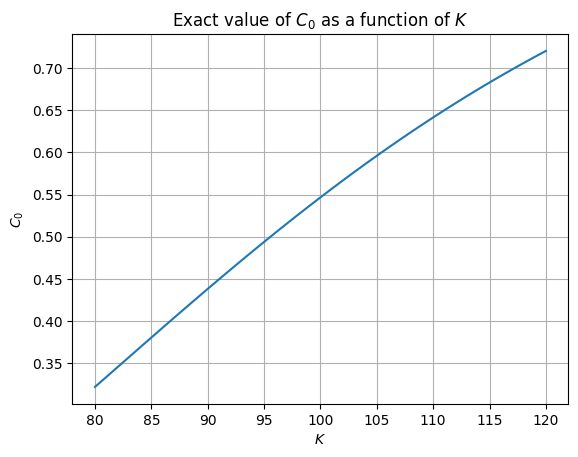

In [55]:
plt.plot(K, [C_0(r, sigma, S_0, T, k) for k in K])
plt.xlabel("$K$")
plt.ylabel("$C_0$")
plt.title("Exact value of $C_0$ as a function of $K$")
plt.grid()
plt.show()

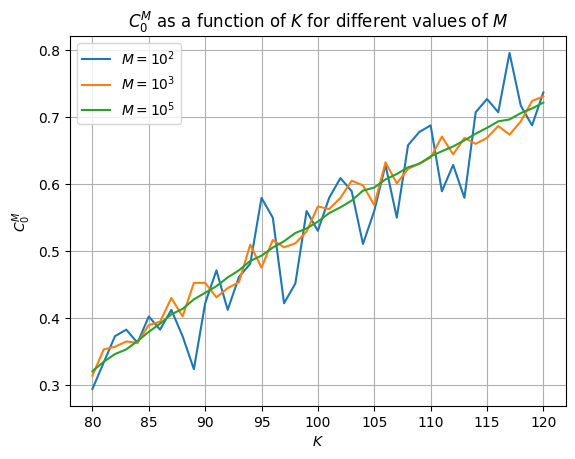

In [63]:
plt.plot(K, [CM_0(r, sigma, S_0, T, k, M=100) for k in K], label="$M=10^2$")
plt.plot(K, [CM_0(r, sigma, S_0, T, k, M=1000) for k in K], label="$M=10^3$")
plt.plot(K, [CM_0(r, sigma, S_0, T, k, M=100000) for k in K], label="$M=10^5$")
plt.xlabel("$K$")
plt.ylabel("$C^M_0$")
plt.title("$C^M_0$ as a function of $K$ for different values of $M$")
plt.legend()
plt.grid()
plt.show()

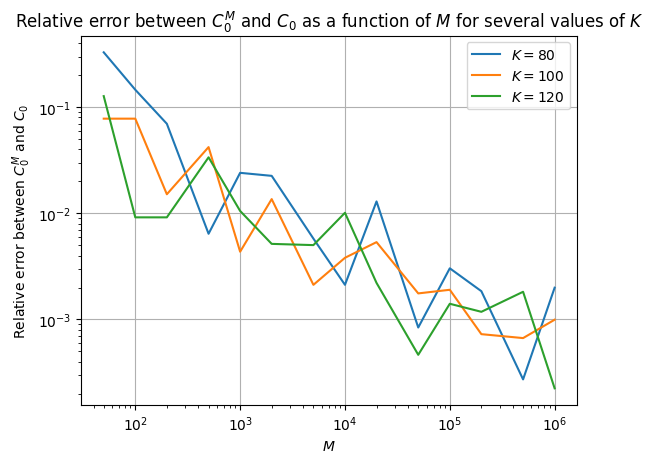

In [96]:
M = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]

for K in [80, 100, 120]:

    CM = np.array([CM_0(r, sigma, S_0, T, K, m) for m in M])
    relative_error = abs(CM - C_0(r, sigma, S_0, T, K))/C_0(r, sigma, S_0, T, K)
    plt.plot(M, relative_error, label=f"$K={K}$")

plt.xscale("log")
plt.xlabel("$M$")
plt.yscale("log")
plt.ylabel("Relative error between $C^M_0$ and $C_0$")
plt.title("Relative error between $C^M_0$ and $C_0$ as a function of $M$ for several values of $K$")
plt.grid()
plt.legend()
plt.show()

2. We denote $C^M_0(S_0)$ to emphasize the dependence of this function on $S_0$.

a. Build a program which returns the centered finite-differences approximation of $\Delta_0$ and the corresponding 5% confidence interval:
$$\Delta^{M,\varepsilon}_0 = \frac{C_0^M(S_0+\varepsilon) - C_0^M(S_0-\varepsilon)}{2\varepsilon}$$

In [97]:
def Delta_MC(r, sigma, S_0, T, K, M, eps):

    return (CM_0(r, sigma, S_0+eps, T, K, M) - CM_0(r, sigma, S_0-eps, T, K, M)) / (2*eps)